# One-vs-all logistic regression classifier

Importing packages.

In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit as sigmoid
from scipy import linalg
import matplotlib.pyplot as plt

Getting data from irisdata.csv.

In [2]:
def getdata():
    global X, Y
    data = pd.read_csv("irisdata.csv")
    X = data[["sepal length", "sepal width", "petal length", "petal width"]].to_numpy()
    X = np.append(np.ones((150,1)), X, axis=1)
    Y = np.zeros((150,3))
    for i in range(150):
        if data["type"][i] == "Iris-setosa":
            Y[i][0] = 1
        if data["type"][i] == "Iris-versicolor":
            Y[i][1] = 1
        if data["type"][i] == "Iris-virginica":
            Y[i][2] = 1

Creating the training set, cross-validation set and test set. Randomly shuffles the data to get iris types distributed (on average) evenly in the 3 sample sets. This introduces randomness in the output, i.e. I will get different learned parameters and accuracies when running the algorithm multiple times. This randomness can be substantial due to the small sample size.

In [3]:
def createsets():
    global X, Y, Xtrain, Ytrain, Xcv, Ycv, Xtest, Ytest
    randperm = np.random.permutation(range(150))
    X = X[randperm, :]
    Y = Y[randperm, :]
    Xtrain = X[0:100, :]
    Ytrain = Y[0:100, :]
    Xcv = X[100:125, :]
    Ycv = Y[100:125, :]
    Xtest = X[125:150, :]
    Ytest = Y[125:150, :]

Calculating the cost associated with the current hypothesis. Used for debugging, finding hyperparameters Alpha and num_iters manually.

In [4]:
def cost(X, y, theta, Lambda):
    return -1/X.shape[0] * (y.T@np.log(sigmoid(X@theta)) + (1-y).T@np.log(1-sigmoid(X@theta))) + Lambda/(2*150)*np.sum(np.square(theta[1:]))

Calculating the gradient of the cost function at the current parameter vector Theta.

In [5]:
def gradient(X, y, Theta, Lambda):
    grad_noreg = 1/150 * X.T@(sigmoid(X@Theta)-y)
    reg = np.copy(Theta)
    reg[0] = 0
    return grad_noreg + Lambda/150 * reg

Implementing batch gradient descent. Runs fast enough (small dataset, few features), so no need for advanced optimisation libraries or stochastic gradient descent. The last parameter calculate_cost is a bool indicating whether we want to save the values of the cost function (for fitting Alpha, num_iters) as the gradient descent iterates.

In [6]:
def gradient_descent(X, y, Lambda, Alpha, num_iters, calculate_cost):
    global cost_history
    Theta = np.zeros((5,1))
    for _ in range(num_iters):
        if calculate_cost:
            cost_history.extend(cost(X,y,Theta,Lambda))
        Theta = Theta - Alpha*gradient(X, y, Theta, Lambda)
    return Theta

Produce the predicted probabilities of being each type of iris.

In [7]:
def predict(X, Theta):
    return sigmoid(X@Theta)

Training the classifier. Concatenates the learned parameter vectors for each group into a global variable Theta (the learned parameter matrix). The last parameter fitted_lambda (bool) indicates whether the regularisation parameter Lambda had been fitted when we train the classifier.

In [8]:
def train(X, Y, Lambda, Alpha, num_iters, fitted_lambda):
    global Theta
    m = Y.shape[0]
    Theta = np.empty((5,3))
    for i in range(3):
        y = Y[:, i].reshape(m,1)
        Theta[:, i] = gradient_descent(X, y, Lambda, Alpha, num_iters, fitted_lambda).reshape(5,)

Transform the probability predictions into a binary output matrix.

In [9]:
def calculate_output():
    global X, Theta, output
    output = np.empty((150,3))
    for i in range(3):
        output[:, i] = predict(X, Theta[:, i]).reshape(150,)
    for i in range(150):
        for j in range(3):
            output[i,j] = int(output[i,j]==np.amax(output[i,:]))

Obtain prediction accuracies for the 3 sample sets. The last parameter fitted_lambda (bool) indicates whether the regularisation parameter Lambda had been fitted when running evaluation (so that we can use the same function for outputting performance metrics and fitting Lambda).

In [10]:
def evaluate(fitted_lambda):
    global Y, output
    train_mistakes = 0
    cv_mistakes = 0
    test_mistakes = 0
    for i in range(150):
        if (output[i, :] != Y[i, :]).any():
            if i in range(100):
                train_mistakes += 1
            if i in range(100, 125):
                cv_mistakes += 1
            if i in range(125, 150):
                test_mistakes += 1
    train_accuracy = 1-train_mistakes/100
    cv_accuracy = 1-cv_mistakes/25
    test_accuracy = 1-test_mistakes/25
    if fitted_lambda:
        print("Training set accuracy: ", train_accuracy)
        print("Cross-validation set accuracy: ", cv_accuracy)
        print("Test set accuracy: ", test_accuracy)
    else:
        return cv_accuracy

Finding the best regularisation hyperparameter Lambda that gives the highest accuracy in the cross-validation set. We could fit the other hyperparameters Alpha and num_iters here but I decided to do that manually by observing the cost as a function of the number of iterations of gradient descent.

In [11]:
def fit_lambda():
    global Xtrain, Ytrain, Xcv, Ycv, Alpha, num_iters
    best_Lambda = -1
    best_cv_accuracy = 0
    for Lambda in [0, 0.01, 0.03, 0.1, 0.3, 1, 3]:
        train(Xtrain, Ytrain, Lambda, Alpha, num_iters, False)
        calculate_output()
        cv_accuracy = evaluate(False)
        if cv_accuracy > best_cv_accuracy:
            best_cv_accuracy = cv_accuracy
            best_Lambda = Lambda
    return best_Lambda

Running the learning algorithm. Setting hyperparameters Alhpa and num_iters manually (based on the diagnostics below).

In [12]:
getdata()
createsets()
Alpha = 0.1
num_iters = 2000
Lambda = fit_lambda()
cost_history = []
train(Xtrain, Ytrain, Lambda, Alpha, num_iters, True)
calculate_output()
evaluate(True)

Training set accuracy:  0.94
Cross-validation set accuracy:  1.0
Test set accuracy:  1.0


Plotting the (resample of) cost as function of gradient descent iterations and the learning curve as diagnostic tools.

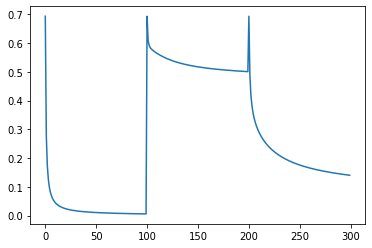

In [13]:
plt.plot(cost_history[0::20])

Drawing the learning curve.

In [14]:
train_costs = []
cv_costs = []
for i in range(1,100):
    X_current = Xtrain[0:i, :]
    Y_current = Ytrain[0:i, :]
    train(X_current, Y_current, Lambda, Alpha, num_iters, False)
    train_cost = 0
    cv_cost = 0
    for j in range(3):
        y_current = Y_current[:,j].reshape(i,1)
        ycv_current = Ycv[:,j].reshape(25,1)
        theta = Theta[:,j].reshape(5,1)
        train_cost += cost(X_current, y_current, theta, Lambda)
        cv_cost += cost(Xcv, ycv_current, theta, Lambda)
    train_costs.extend(train_cost)
    cv_costs.extend(cv_cost)

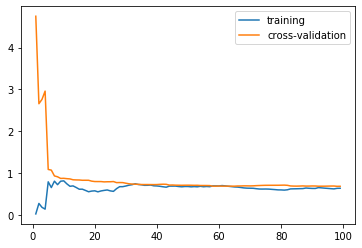

In [15]:
plt.plot(range(1,100), train_costs, label="training")
plt.plot(range(1,100), cv_costs, label="cross-validation")
plt.legend()
plt.show()